# Import Libraries

## Base Libraries

In [1]:
import sys
sys.path.append('../')

In [2]:
import datetime

In [3]:
import os

In [4]:
import pickle

## Installed Libraries

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [5]:
import xgboost as xgb

In [6]:
from sklearn.model_selection import GridSearchCV

In [7]:
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix

In [8]:
from sklearn.metrics import PrecisionRecallDisplay

In [9]:
import matplotlib.pyplot as plt

In [10]:
%matplotlib inline

In [11]:
import numpy as np

In [16]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Read Dataset

In [14]:
# Procssed version of "../data/interim/FakeNewsNet.tsv", which augments truncated true news content
df = pd.read_csv("MisInfoText_BuzzFeedWebis_cleaned.csv")

In [15]:
df.shape

(1371, 8)

In [17]:
df.head()

id                                author orientation          portal  \
0  315                      Antiphon Freeman        left  addicting-info   
1  314  Posted by John Prager on 26 Sep 2016        left  addicting-info   
2  311                           John Prager        left  addicting-info   
3  309                       Wendy Gittleson        left  addicting-info   
4  308                                  Vera        left  addicting-info   

                                               title  \
0  Trump Campaign Manager: Trump Doesnât Lie, H...   
1                                                NaN   
2  Donald Trump Attacked Clintonâs âStaminaâ...   
3  New Study Proves America Keeps Getting Better ...   
4  Biographer Says Trump Might Not Actually Be A ...   

                                 article_url_cleaned  \
0  https://news.groopspeak.com/trump-campaign-man...   
1  https://winningdemocrats.com/whoa-trump-just-a...   
2  https://addictinginfo.org/2016/09/26/donald-tr...   
3  https://author.addictinginfo.org/2016/09/26/ne...   
4  https://author.addictinginfo.org/2016/09/26/bi...   

                                article_body_cleaned  \
0  DonaldTrump campaign manager Kellyanne Conway ...   
1  Posted by John Prager on 26 Sep 2016 Through t...   
2  AfterMonday debate, Donald Trump almost certai...   
3  The cornerstone of DonaldTrump presidential ca...   
4  DonaldTrump lies are catching up to him one by...   

  article_veracity_label_cleaned  
0                    mostly true  
1      mixture of true and false  
2                    mostly true  
3                    mostly true  
4                    mostly true

### Change text label into number

0: mostly true

1: mostly false

2: mixture of true and false

3: no factual content

In [37]:
df['article_veracity_label_cleaned'].replace(['mostly true','mostly false','mixture of true and false','no factual content'],
                        [0,1,2,3], inplace=True)

In [39]:
df.rename(columns = {'article_body_cleaned':'text', 'article_veracity_label_cleaned':'label'}, inplace = True)

In [40]:
#df_dedup = df.drop_duplicates(["id_3"])[["id_3", "title", "text", "label"]]
df_dedup = df[['id','orientation','text','label']]

In [43]:
df_dedup.head()

id orientation                                               text  label
0  315        left  DonaldTrump campaign manager Kellyanne Conway ...      0
1  314        left  Posted by John Prager on 26 Sep 2016 Through t...      2
2  311        left  AfterMonday debate, Donald Trump almost certai...      0
3  309        left  The cornerstone of DonaldTrump presidential ca...      0
4  308        left  DonaldTrump lies are catching up to him one by...      0

In [44]:
df_dedup.shape

(1371, 4)

# Feature Engineering

## Lexicon-level

In [45]:
pipe_lex = Pipeline([('count', CountVectorizer()),
                 ('tfid', TfidfTransformer(norm='l1', 
                                           use_idf=False))]).fit(df_dedup["text"])

In [46]:
lex_matrix_props = pipe_lex.transform(df_dedup["text"])

# Model Data Preparation

In [47]:
lex_matrix_props.A.shape

(1371, 30141)

In [48]:
X = lex_matrix_props.A.copy()

In [49]:
X.shape

(1371, 30141)

In [50]:
assert X.shape[1] == lex_matrix_props.A.shape[1]

In [51]:
y = df_dedup["label"].to_numpy()
idx = df_dedup["id"].to_numpy()

In [52]:
(
    X_train, 
    X_test, 
    y_train, 
    y_test,
    idx_train,
    idx_test
) = train_test_split(X, y, idx, test_size=0.2, random_state=42)

# Model Building

In [53]:
xgb_model = xgb.XGBClassifier(n_jobs=2, use_label_encoder=False, eval_metric='logloss')

In [54]:
clf = GridSearchCV(estimator=xgb_model, 
                         param_grid={'max_depth': [2, 4, 6, 8],
                                     'n_estimators': [50, 100, 150, 200]
                                    },
                   scoring='f1',
                   verbose=1,
                   n_jobs=2)

In [ ]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


# Model Evaluation

Model hyperparameters with best performance

In [29]:
print(clf.best_params_)

{'max_depth': 4, 'n_estimators': 50}


In [30]:
feature_names = list(pipe_lex["count"].get_feature_names_out())
clf.best_estimator_.get_booster().feature_names = feature_names

## Model Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

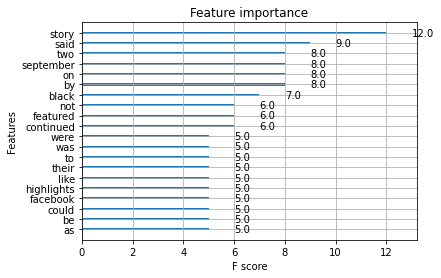

In [31]:
xgb.plot_importance(clf.best_estimator_, max_num_features=20)

## Model Explanation: SHAP Summary Plot (Full Dataset)

In [32]:
explainer = shap.TreeExplainer(clf.best_estimator_, 
                                 feature_names=feature_names)

In [33]:
shap_values = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


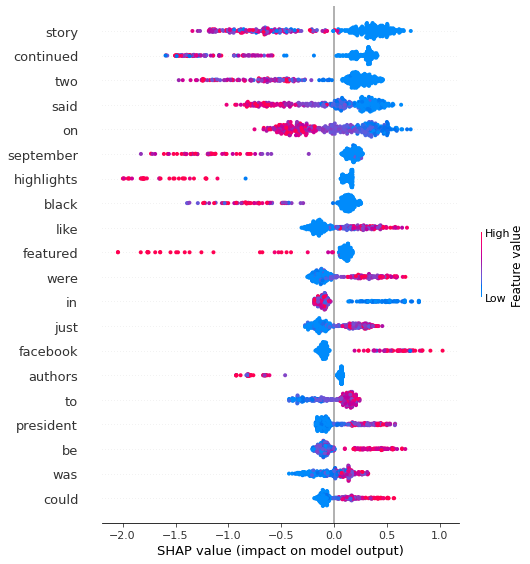

In [34]:
shap.summary_plot(shap_values, X)

## Full Test Set

Classification Report per Class

In [35]:
y_test_pred = clf.predict(X_test)

In [36]:
y_test_score = clf.predict_proba(X_test)[:,1]

In [37]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.77      0.82        44
           1       0.76      0.86      0.81        36

    accuracy                           0.81        80
   macro avg       0.81      0.82      0.81        80
weighted avg       0.82      0.81      0.81        80



Precision-Recall Curve

In [38]:
precision, recall, thresholds = precision_recall_curve(y_true=y_test, 
                                                       probas_pred=y_test_score)

In [39]:
f1_scores = 2*precision*recall/(precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]

In [40]:
print("Optimal Threshold:", optimal_threshold)
print("Optimal F1 Score:", np.max(f1_scores))

Optimal Threshold: 0.30082986
Optimal F1 Score: 0.8292682926829269


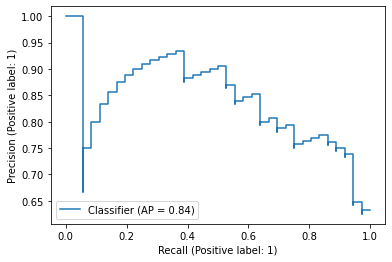

In [41]:
PrecisionRecallDisplay.from_predictions(y_true=y_test, y_pred=y_test_score)

Confusion Matrix

In [42]:
confusion_matrix(y_true=y_test, y_pred=y_test_pred)

array([[34, 10],
       [ 5, 31]])

## Model Performance per Curator

In [43]:
buzzfeed_ids = df[df["curator"] == "BuzzFeed"]["id_3"].unique()
politifact_ids = df[df["curator"] == "PolitiFact"]["id_3"].unique()

### BuzzFeed

In [44]:
buzzfeed_test_ids_indices = np.where(np.isin(idx_test, buzzfeed_ids))

In [45]:
X_test_buzzfeed = X_test[buzzfeed_test_ids_indices,:]

In [46]:
y_test_buzzfeed = y_test[buzzfeed_test_ids_indices]

In [47]:
y_test_pred_buzzfeed = y_test_pred[buzzfeed_test_ids_indices]

In [48]:
y_test_score_buzzfeed = y_test_score[buzzfeed_test_ids_indices]

Classification Report per Class

In [49]:
print(classification_report(y_test_buzzfeed, y_test_pred_buzzfeed))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83        26
           1       0.75      0.71      0.73        17

    accuracy                           0.79        43
   macro avg       0.78      0.78      0.78        43
weighted avg       0.79      0.79      0.79        43



Precision-Recall Curve

In [50]:
precision_buzzfeed, recall_buzzfeed, thresholds_buzzfeed = precision_recall_curve(y_true=y_test_buzzfeed, 
                                                       probas_pred=y_test_score_buzzfeed)

In [51]:
f1_scores_buzzfeed = 2*precision_buzzfeed*recall_buzzfeed/(precision_buzzfeed + recall_buzzfeed)
optimal_threshold_buzzfeed = thresholds_buzzfeed[np.argmax(f1_scores_buzzfeed)]

In [52]:
print("Optimal Threshold:", optimal_threshold_buzzfeed)
print("Optimal F1 Score:", np.max(f1_scores_buzzfeed))

Optimal Threshold: 0.30082986
Optimal F1 Score: 0.8333333333333333


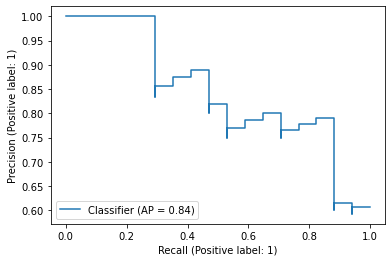

In [53]:
PrecisionRecallDisplay.from_predictions(y_true=y_test_buzzfeed, y_pred=y_test_score_buzzfeed)

Confusion Matrix

In [54]:
confusion_matrix(y_true=y_test_buzzfeed, y_pred=y_test_pred_buzzfeed)

array([[22,  4],
       [ 5, 12]])

### PolitiFact

In [55]:
politifact_test_ids_indices = np.where(np.isin(idx_test, politifact_ids))

In [56]:
X_test_politifact = X_test[politifact_test_ids_indices,:]

In [57]:
y_test_politifact = y_test[politifact_test_ids_indices]

In [58]:
y_test_pred_politifact = y_test_pred[politifact_test_ids_indices]

In [59]:
y_test_score_politifact = y_test_score[politifact_test_ids_indices]

Classification Report per Class

In [60]:
print(classification_report(y_test_politifact, y_test_pred_politifact))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80        18
           1       0.76      1.00      0.86        19

    accuracy                           0.84        37
   macro avg       0.88      0.83      0.83        37
weighted avg       0.88      0.84      0.83        37



Precision-Recall Curve

In [61]:
precision_politifact, recall_politifact, thresholds_politifact = precision_recall_curve(y_true=y_test_politifact, 
                                                       probas_pred=y_test_score_politifact)

In [62]:
f1_scores_politifact = 2*precision_politifact*recall_politifact/(precision_politifact + recall_politifact)
optimal_threshold_politifact = thresholds_politifact[np.argmax(f1_scores_politifact)]

In [63]:
print("Optimal Threshold:", optimal_threshold_politifact)
print("Optimal F1 Score:", np.max(f1_scores_politifact))

Optimal Threshold: 0.5961463
Optimal F1 Score: 0.8636363636363636


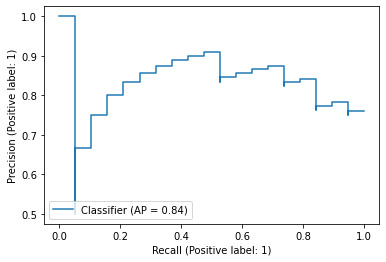

In [64]:
PrecisionRecallDisplay.from_predictions(y_true=y_test_politifact, y_pred=y_test_score_politifact)

Confusion Matrix

In [65]:
confusion_matrix(y_true=y_test_politifact, y_pred=y_test_pred_politifact)

array([[12,  6],
       [ 0, 19]])

# Save Model

In [66]:
today = datetime.datetime.today().strftime('%Y-%m-%d')

In [67]:
model_id = "VeriFYI__FakeNewsDetector__text_lexicon__"+today

In [68]:
clf.best_estimator_.save_model("../models/"+model_id+".json")

# Save Data

## Training Data

In [69]:
df_train = pd.DataFrame(X_train, columns=feature_names)

In [70]:
df_train.shape

(316, 15947)

In [71]:
label_col = "news_label"
assert label_col not in df_train.columns

In [72]:
df_train[label_col] = y_train

In [73]:
idx_col = "idx_col"
assert idx_col not in df_train.columns

In [74]:
df_train[idx_col] = idx_train

In [75]:
score_col = "model_score"
assert score_col not in df_train.columns

In [76]:
df_train[score_col] = clf.predict_proba(X_train)[:,1]

In [77]:
df_train.shape

(316, 15950)

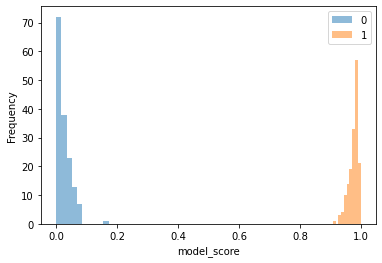

In [78]:
ax = df_train.groupby([label_col])[score_col].plot(kind='hist', legend=True, alpha=0.5)
plt.xlabel(score_col)
plt.show()

In [79]:
df_train.to_csv("../data/processed/"+model_id+"_train.csv", index=False)

## Test Data

In [80]:
df_test = pd.DataFrame(X_test, columns=feature_names)

In [81]:
df_test.shape

(80, 15947)

In [82]:
assert label_col not in df_test.columns
assert idx_col not in df_test.columns
assert score_col not in df_test.columns

In [83]:
df_test[label_col] = y_test

In [84]:
df_test[idx_col] = idx_test

In [85]:
df_test[score_col] = y_test_score

In [86]:
df_test.shape

(80, 15950)

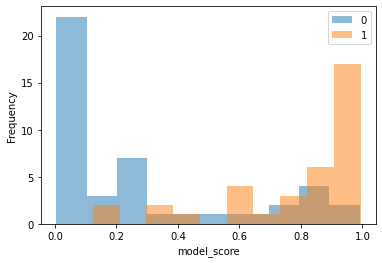

In [87]:
ax = df_test.groupby([label_col])[score_col].plot(kind='hist', legend=True, alpha=0.5)
plt.xlabel(score_col)
plt.show()

In [88]:
df_test.to_csv("../data/processed/"+model_id+"_test.csv", index=False)

# Save Pipeline

In [89]:
with open("../models/"+model_id+"__lexicon_pipeline.pickle", 'wb') as f:
    pickle.dump(pipe_lex, f)

# Model Error Analysis

In [157]:
optimal_threshold = 0.30082986 # From above analysis on full test set

In [158]:
pred_col = "pred_label"
assert pred_col not in df_test.columns
df_test["pred_label"] = np.where(df_test[score_col] > optimal_threshold, 1, 0)

## False Positives

In [164]:
df_test_fp = df_test[(df_test[pred_col] == 1) & (df_test[label_col] == 0)]

In [165]:
df_test_fp.shape

(12, 15951)

In [166]:
shap_values_fp = explainer(df_test_fp[feature_names])

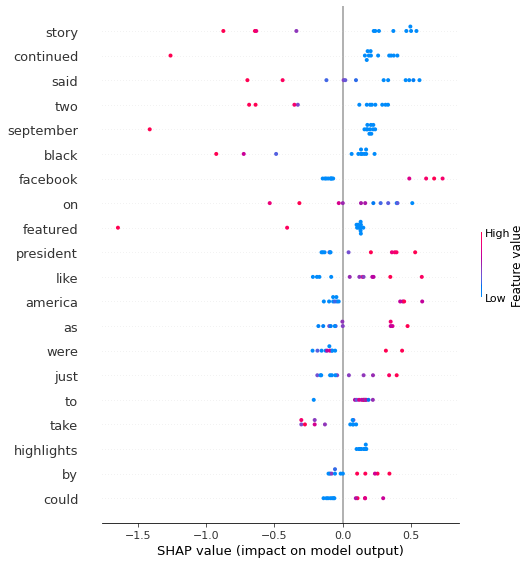

In [167]:
shap.summary_plot(shap_values_fp, df_test_fp[feature_names])

## False Negatives

In [168]:
df_test_fn = df_test[(df_test[pred_col] == 0) & (df_test[label_col] == 1)]

In [169]:
df_test_fn.shape

(3, 15951)

In [170]:
shap_values_fn = explainer(df_test_fn[feature_names])

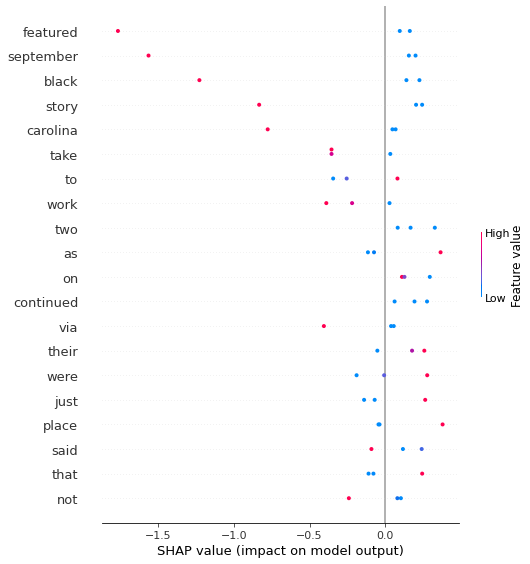

In [171]:
shap.summary_plot(shap_values_fn, df_test_fn[feature_names])

In [172]:
df_test.to_csv("../data/processed/"+model_id+"_test.csv", index=False)